<a href="https://colab.research.google.com/github/astralcai/music-genre-classification/blob/master/attention_rnn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from google.colab import drive
import pickle
drive.mount('/content/drive/', force_remount=True)

TensorFlow 2.x selected.
Mounted at /content/drive/


In [0]:
spectrograms = pickle.load(open('/content/drive/My Drive/mgc_dataset/Copy of gtzan_spectrograms_3_1024.p', 'rb'))
labels = pickle.load(open('/content/drive/My Drive/mgc_dataset/Copy of gtzan_labels_3_1024.p', 'rb'))

In [3]:
spectrograms = np.transpose(spectrograms, axes=(0,2,1))  # put time on the x-axis
data_shape = spectrograms.shape[1:]
print(data_shape)

(128, 513)


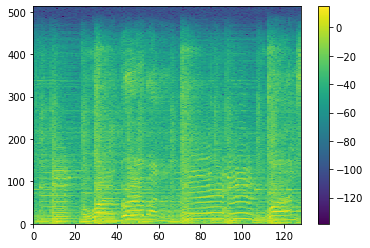

In [4]:
import matplotlib.pyplot as plt
plt.pcolormesh(np.linspace(0,data_shape[0],data_shape[0]), np.linspace(0,data_shape[1],data_shape[1]), 10*np.log10(spectrograms[0]).T)
plt.colorbar()
plt.show()

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [0]:
def make_rnn():

  input_layer = layers.Input(shape=(data_shape[0], data_shape[1]), name="input")
  input_extended = tf.keras.backend.expand_dims(input_layer)

  # BGRU data flow
  rnn_layer_1 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_1")(input_layer)
  rnn_layer_2 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_2")(rnn_layer_1)
  brnn = layers.concatenate([rnn_layer_1, rnn_layer_2], name="BGRU_output")

  # decoder
  average_layer = layers.AveragePooling2D(pool_size=(127,1))(tf.keras.backend.expand_dims(brnn))
  # hidden_layer = layers.Dense(units=64, activation="relu")(layers.Flatten()(average_layer))
  classifier = layers.Dense(units=5, activation="softmax")(layers.Flatten()(average_layer))
  model = Model(inputs=input_layer, outputs=classifier)
  return model

def make_rnn_attention():

  input_layer = layers.Input(shape=(data_shape[0], data_shape[1]), name="input")
  input_extended = tf.keras.backend.expand_dims(input_layer)

  # BGRU data flow
  rnn_layer_1 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_1")(input_layer)
  rnn_layer_2 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_2")(rnn_layer_1)
  brnn = layers.concatenate([rnn_layer_1, rnn_layer_2], name="BGRU_output")

  # CNN attention network
  dropout = layers.Dropout(0.2)
  conv_1 = layers.Conv2D(32, 3, padding="same", name="conv_1")(dropout(input_extended))
  bn_1 = layers.BatchNormalization()(conv_1)
  relu_1 = layers.ReLU()(bn_1)
  pool_1 = layers.MaxPool2D(pool_size=(2,2))(relu_1)
  conv_2 = layers.Conv2D(64, 3, padding="same", name="conv_2")(dropout(pool_1))
  bn_2 = layers.BatchNormalization()(conv_2)
  relu_2 = layers.ReLU()(bn_2)
  pool_2 = layers.MaxPool2D(pool_size=(2,2))(relu_2)
  conv_3 = layers.Conv2D(32, 3, padding="same", name="conv_3")(dropout(pool_2))
  bn_3 = layers.BatchNormalization()(conv_3)
  relu_3 = layers.ReLU()(bn_3)
  pool_3 = layers.MaxPool2D(pool_size=(2,2))(relu_3)
  # conv_4 = layers.Conv2D(128, 3, padding="same", name="conv_4")(dropout(pool_3))
  # bn_4 = layers.BatchNormalization()(conv_4)
  # relu_4 = layers.ReLU()(bn_4)
  # pool_4 = layers.MaxPool2D(pool_size=(4,4))(relu_4)
  # conv_5 = layers.Conv2D(64, 3, padding="same", name="conv_5")(dropout(pool_4))
  # bn_5 = layers.BatchNormalization()(conv_5)
  # relu_5 = layers.ReLU()(bn_5)
  # pool_5 = layers.MaxPool2D(pool_size=(4,4))(relu_5)
  scores = layers.Dense(units=data_shape[0], activation="softmax")(layers.Flatten()(pool_3))

  # decoder
  fusion_layer = layers.Dot((1,1))([brnn, tf.keras.backend.expand_dims(scores)])
  # hidden_layer = layers.Dense(units=32, activation="relu")(layers.Flatten()(fusion_layer))
  classifier = layers.Dense(units=5, activation="softmax")(layers.Flatten()(fusion_layer))
  model = Model(inputs=input_layer, outputs=classifier)

  return model

def make_cnn():

  input_layer = layers.Input(shape=(data_shape[0], data_shape[1]), name="input")
  input_extended = tf.keras.backend.expand_dims(input_layer)

  # CNN attention network
  dropout = layers.Dropout(0.2)
  conv_1 = layers.Conv2D(32, 3, padding="same", name="conv_1")(dropout(input_extended))
  bn_1 = layers.BatchNormalization()(conv_1)
  relu_1 = layers.ReLU()(bn_1)
  pool_1 = layers.MaxPool2D(pool_size=(2,2))(relu_1)
  conv_2 = layers.Conv2D(64, 3, padding="same", name="conv_2")(dropout(pool_1))
  bn_2 = layers.BatchNormalization()(conv_2)
  relu_2 = layers.ReLU()(bn_2)
  pool_2 = layers.MaxPool2D(pool_size=(2,2))(relu_2)
  conv_3 = layers.Conv2D(32, 3, padding="same", name="conv_3")(dropout(pool_2))
  bn_3 = layers.BatchNormalization()(conv_3)
  relu_3 = layers.ReLU()(bn_3)
  pool_3 = layers.MaxPool2D(pool_size=(2,2))(relu_3)
  # conv_4 = layers.Conv2D(128, 3, padding="same", name="conv_4")(dropout(pool_3))
  # bn_4 = layers.BatchNormalization()(conv_4)
  # relu_4 = layers.ReLU()(bn_4)
  # pool_4 = layers.MaxPool2D(pool_size=(4,4))(relu_4)
  # conv_5 = layers.Conv2D(64, 3, padding="same", name="conv_5")(dropout(pool_4))
  # bn_5 = layers.BatchNormalization()(conv_5)
  # relu_5 = layers.ReLU()(bn_5)
  # pool_5 = layers.MaxPool2D(pool_size=(4,4))(relu_5)
  scores = layers.Dense(units=data_shape[0], activation="softmax")(layers.Flatten()(pool_3))

  classifier = layers.Dense(units=5, activation="softmax")(layers.Flatten()(pool_3))
  model = Model(inputs=input_layer, outputs=classifier)
  return model

def make_parallel_cnn_rnn():

  input_layer = layers.Input(shape=(data_shape[0], data_shape[1]), name="input")
  input_extended = tf.keras.backend.expand_dims(input_layer)

  # BGRU data flow
  rnn_layer_1 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_1")(input_layer)
  rnn_layer_2 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_2")(rnn_layer_1)
  brnn = layers.concatenate([rnn_layer_1, rnn_layer_2], name="BGRU_output")

  # CNN attention network
  dropout = layers.Dropout(0.2)
  conv_1 = layers.Conv2D(32, 3, padding="same", name="conv_1")(dropout(input_extended))
  bn_1 = layers.BatchNormalization()(conv_1)
  relu_1 = layers.ReLU()(bn_1)
  pool_1 = layers.MaxPool2D(pool_size=(2,2))(relu_1)
  conv_2 = layers.Conv2D(64, 3, padding="same", name="conv_2")(dropout(pool_1))
  bn_2 = layers.BatchNormalization()(conv_2)
  relu_2 = layers.ReLU()(bn_2)
  pool_2 = layers.MaxPool2D(pool_size=(2,2))(relu_2)
  conv_3 = layers.Conv2D(32, 3, padding="same", name="conv_3")(dropout(pool_2))
  bn_3 = layers.BatchNormalization()(conv_3)
  relu_3 = layers.ReLU()(bn_3)
  pool_3 = layers.MaxPool2D(pool_size=(2,2))(relu_3)
  # conv_4 = layers.Conv2D(128, 3, padding="same", name="conv_4")(dropout(pool_3))
  # bn_4 = layers.BatchNormalization()(conv_4)
  # relu_4 = layers.ReLU()(bn_4)
  # pool_4 = layers.MaxPool2D(pool_size=(4,4))(relu_4)
  # conv_5 = layers.Conv2D(64, 3, padding="same", name="conv_5")(dropout(pool_4))
  # bn_5 = layers.BatchNormalization()(conv_5)
  # relu_5 = layers.ReLU()(bn_5)
  # pool_5 = layers.MaxPool2D(pool_size=(4,4))(relu_5)
  scores = layers.Dense(units=1024, activation="softmax")(layers.Flatten()(pool_3))

  # decoder
  average_layer = layers.AveragePooling2D(pool_size=(127,1))(tf.keras.backend.expand_dims(brnn))
  # hidden_layer = layers.Dense(units=32, activation="relu")(layers.Flatten()(fusion_layer))
  fusion_layer = layers.concatenate([layers.Flatten()(average_layer), scores])
  classifier = layers.Dense(units=5, activation="softmax")(layers.Flatten()(fusion_layer))
  model = Model(inputs=input_layer, outputs=classifier)
  return model

In [0]:
Y = tf.keras.utils.to_categorical(labels, num_classes=5)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(spectrograms, Y, test_size=0.2)

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# make models
rnn_model = make_rnn()
attention_rnn_model = make_rnn_attention()
cnn_model = make_cnn()
parallel_model = make_parallel_cnn_rnn()

for model, name in zip([rnn_model, attention_rnn_model, cnn_model, parallel_model], ["RNN", "RNN with Attention", "CNN", "Parallel Model"]):
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  model.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[callback], verbose=False)
  result = model.evaluate(X_test, y_test)
  print("{} Test Accuracy: {:.2f}".format(name, result[1]))


905/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [21]:
from sklearn.metrics import confusion_matrix
y_pred = rnn_model.predict(X_test)
y_test_cat = [np.argmax(y) for y in y_test]
y_pred = [np.argmax(y) for y in y_pred]
cm = confusion_matrix(y_test_cat, y_pred)
cm

array([[153,   0,  12,   0,  15],
       [  2, 165,   2,   3,   5],
       [  3,   0, 179,   4,   7],
       [  4,   5,   4, 153,  11],
       [  0,   1,  10,   5, 162]])